<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/logistic_regression_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
# Import general python libaries
import os
import json
import pandas as pd
import numpy as np
import importlib

# Google Cloud libraries
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata
import pandas_gbq

# Scikit Learn libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Other
from matplotlib import pyplot
import seaborn as sns


In [80]:
# Mount Google Drive
drive.mount('/content/drive')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df

In [ ]:
# Authentication credentials and keys

# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [ ]:
# Feature Data

fa_cup_raw_features = """
    SELECT * FROM preparation_layer.view_fa_cup_round_3_features WHERE season_year NOT IN ('21/22', '22/23')
"""

fa_cup_raw_features_df = client.query(fa_cup_raw_features).to_dataframe().drop(columns=['season_year'])
display(fa_cup_raw_features_df)


all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
display(all_results_df)


,arena_stadium_capacity,home_team_league_level,home_win,home_team_round_3_position,home_team_massey,home_team_colley,home_team_keener,home_team_trueskill,home_team_borda_count,home_team_local_kemeny_optimisation,...,match_weather_data_hours_dew,match_weather_data_hours_precip,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,target_variable
0,41837,1,1,1,1,1,12,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
1,41837,1,1,1,1,1,12,1,1,1,...,34.70,0.000,0.0,0.00,4.80,1036.70,2.05,95.90,Overcast,0
2,41837,1,1,1,1,1,12,1,1,1,...,47.00,0.000,0.0,0.00,2.10,1031.70,4.20,87.00,Partially cloudy,0
3,74879,1,1,1,1,1,12,1,1,1,...,71.20,0.000,NaN,0.00,7.65,1015.50,5.15,67.10,Partially cloudy,0
4,74879,1,0,2,3,7,4,6,4,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,<NA>,6,0,64,58,64,57,63,64,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
301,<NA>,6,0,64,58,64,57,63,64,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
302,9527,4,1,64,58,64,57,63,64,64,...,37.15,0.000,0.0,0.00,14.45,1012.75,9.00,94.25,Overcast Partially cloudy,1
303,6064,6,0,64,58,64,57,63,64,64,...,41.45,0.000,0.0,0.00,6.35,1036.35,15.15,98.65,Overcast,0


,metric_id,metric


In [ ]:
def add_home_advantage(X):

    result = X.groupby(['home_team_league_level', 'away_team_league_level'])['home_win'].mean().reset_index()
    result.columns = ['home_team_league_level', 'away_team_league_level', 'home_win_factor']
    result['home_win_factor'] = result['home_win_factor'].round(3)

    X = X.merge(result, on=['home_team_league_level', 'away_team_league_level'], how='left')
    return X, 'home_win_factor'

In [67]:
# Function to calculate weights
def calculate_weights(y):
    class_counts = y.value_counts()
    total_samples = len(y)
    return {class_label: int(round((1 - (count / total_samples)) * 100))
            for class_label, count in class_counts.items()}


In [82]:
def classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state = 47):

  # Empty df for consolidating results
  all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
  fold_results = []

  # Define the ranking systems
  ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

  # Get all columns except the target and ranking columns
  target_variable = 'target_variable'
  base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

  # Identify numeric and categorical columns
  numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
  categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

  # Define preprocessing steps

  numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', MinMaxScaler())
  ])

  categorical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='most_frequent')),
      ('onehot', OneHotEncoder(handle_unknown='ignore'))
  ])

  ranking_transformer = Pipeline(steps=[
      ('scaler', MinMaxScaler())
  ])

  # Define cross-validation strategy
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

  # Loop through each ranking system
  for ranking in ranking_systems:
      model_name_ranking = f"{model_name} {ranking}"
      print(model_name_ranking)

      if ranking == 'no_ranking':
          # Use all base features without ranking
          X = fa_cup_raw_features_df[base_features]
      else:
          # Include ranking features
          current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
          X = fa_cup_raw_features_df[current_features]

      y = fa_cup_raw_features_df['target_variable']

      # Initialize lists to store results for each fold of the model
      fold_accuracies = []
      fold_recalls = []
      confusion_matrices = []
      classification_reports = []
      all_y_true = []
      all_y_pred = []
      all_y_pred_proba = []  # Store probabilities for ROC

      # Perform cross-validation
      skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
      for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
          X_train, X_val = X.iloc[train_index], X.iloc[val_index]
          y_train, y_val = y.iloc[train_index], y.iloc[val_index]

           # Add home advantage if specified
          if home_advt == 'yes':
              X_train, home_advantage_column = add_home_advantage(X_train)
              X_val, _ = add_home_advantage(X_val)
              numeric_features = [home_advantage_column] + numeric_features

          # Update preprocessor
          if ranking == 'no_ranking':
              preprocessor = ColumnTransformer(
                  transformers=[
                      ('num', numeric_transformer, numeric_features),
                      ('cat', categorical_transformer, categorical_features)
                  ], verbose_feature_names_out=False)

          else:
              preprocessor = ColumnTransformer(
                  transformers=[
                      ('num', numeric_transformer, numeric_features),
                      ('cat', categorical_transformer, categorical_features),
                      ('rank', numeric_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
                  ], verbose_feature_names_out=False)


          if weighted == 'yes':
             # Calculate weights using only training data
              weights = calculate_weights(y_train)

          # Create pipeline
          pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model_classifier)
            ])

          # Create GridSearchCV object
          grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall', n_jobs=-1)

          # Fit GridSearchCV
          grid_search.fit(X_train, y_train)

          # Get best model
          best_model = grid_search.best_estimator_

          # Print the best recall from GridSearchCV
          print(f"Best parameters: {grid_search.best_params_}")
          print(f"Best Estimator's Recall (from GridSearchCV): {grid_search.best_score_:.3f}")

          # Make predictions
          y_pred = best_model.predict(X_val)
          y_pred_proba = best_model.predict_proba(X_val)[:, 1] # Probabilities for the positive class and ROC curve/AUC Score

          # Calculate accuracy
          accuracy = accuracy_score(y_val, y_pred)
          fold_accuracies.append(accuracy)

          # Calculate recall
          recall = recall_score(y_val, y_pred)
          fold_recalls.append(recall)

          # Store fold results
          fold_results.append({
              'Model Name Ranking': model_name_ranking,
              'Fold': fold,
              'Best Parameters (GridSearchCV)': grid_search.best_params_,
              'Best Recall (GridSearchCV)': grid_search.best_score_,
              'Validation Accuracy': accuracy,
              'Validation Recall': recall
          })

          # Confusion matrix
          cm = confusion_matrix(y_val, y_pred)
          confusion_matrices.append(cm)

          # Generate classification report
          cr = classification_report(y_val, y_pred, output_dict=True)
          classification_reports.append(cr)

          # Store true and predicted values for later analysis
          all_y_true.extend(y_val)
          all_y_pred.extend(y_pred)
          all_y_pred_proba.extend(y_pred_proba)

          print(f"Fold {fold} Accuracy: {accuracy:.3f}")
          print(f"Fold {fold} Recall: {recall:.3f}")

      # Calculate average accuracy
      avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
      print(f"Average Accuracy: {avg_accuracy:.3f}")

      # Calculate average recall
      avg_recall = sum(fold_recalls) / len(fold_recalls)
      print(f"Average Recall: {avg_recall:.3f}")

      # Create and display results using existing function
      results_df, cm_fig, roc_fig = create_model_results_df(all_y_true, all_y_pred, fold_accuracies, fold_recalls,  all_y_pred_proba, model_name_ranking)
      results_df = results_df.reset_index()
      results_df['metric_id'] = results_df.index + 1
      results_df = results_df[['metric_id', 'metric', model_name_ranking]]

      all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')

      fold_results_df = pd.DataFrame(fold_results)

  return all_results_df, fold_results_df

Standard LogisticRegression no_ranking
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.348
Fold 1 Accuracy: 0.705
Fold 1 Recall: 0.188
Best parameters: {'classifier__C': 1000.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.394
Fold 2 Accuracy: 0.639
Fold 2 Recall: 0.250
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.348
Fold 3 Accuracy: 0.639
Fold 3 Recall: 0.188
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.411
Fold 4 Accuracy: 0.689
Fold 4 Recall: 0.118
Best parameters: {'classifier__C': 1000.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.383


,metric_id,metric,Standard LogisticRegression no_ranking,Standard LogisticRegression round_3_position,Standard LogisticRegression massey,Standard LogisticRegression colley,Standard LogisticRegression keener,Standard LogisticRegression trueskill,Standard LogisticRegression borda_count,Standard LogisticRegression local_kemeny_optimisation
0,1,Cross-validation Accuracy Mean,0.679,0.705,0.692,0.685,0.669,0.685,0.675,0.675
1,2,Cross-validation Accuracy Standard Deviation,0.034,0.036,0.026,0.039,0.043,0.035,0.043,0.047
2,3,Cross-validation Recall Mean,0.184,0.268,0.221,0.220,0.185,0.220,0.207,0.195
3,4,Cross-validation Recall Standard Deviation,0.034,0.036,0.026,0.039,0.043,0.035,0.043,0.047
4,5,Overall Accuracy,0.679,0.705,0.692,0.685,0.669,0.685,0.675,0.675
5,6,Confusion Matrix - True Negative (Class 0),192.000,193.000,193.000,191.000,189.000,191.000,189.000,190.000
6,7,Confusion Matrix - False Positive (Class 1),31.000,30.000,30.000,32.000,34.000,32.000,34.000,33.000
7,8,Confusion Matrix - False Negative (Class 0),67.000,60.000,64.000,64.000,67.000,64.000,65.000,66.000
8,9,Confusion Matrix - True Positive (Class 1),15.000,22.000,18.000,18.000,15.000,18.000,17.000,16.000
9,10,Precision (Class 0),0.741,0.763,0.751,0.749,0.738,0.749,0.744,0.742


,Model Name Ranking,Fold,Best Parameters (GridSearchCV),Best Recall (GridSearchCV),Validation Accuracy,Validation Recall
0,Standard LogisticRegression no_ranking,1,"{'classifier__C': 10.0, 'classifier__penalty':...",0.348485,0.704918,0.187500
1,Standard LogisticRegression no_ranking,2,"{'classifier__C': 1000.0, 'classifier__penalty...",0.393939,0.639344,0.250000
2,Standard LogisticRegression no_ranking,3,"{'classifier__C': 100.0, 'classifier__penalty'...",0.348485,0.639344,0.187500
3,Standard LogisticRegression no_ranking,4,"{'classifier__C': 10.0, 'classifier__penalty':...",0.411255,0.688525,0.117647
4,Standard LogisticRegression no_ranking,5,"{'classifier__C': 1000.0, 'classifier__penalty...",0.383117,0.721311,0.176471
5,Standard LogisticRegression round_3_position,1,"{'classifier__C': 1000.0, 'classifier__penalty...",0.378788,0.721311,0.250000
6,Standard LogisticRegression round_3_position,2,"{'classifier__C': 10.0, 'classifier__penalty':...",0.424242,0.672131,0.312500
7,Standard LogisticRegression round_3_position,3,"{'classifier__C': 100.0, 'classifier__penalty'...",0.393939,0.655738,0.250000
8,Standard LogisticRegression round_3_position,4,"{'classifier__C': 10.0, 'classifier__penalty':...",0.365079,0.754098,0.294118
9,Standard LogisticRegression round_3_position,5,"{'classifier__C': 1000.0, 'classifier__penalty...",0.476912,0.721311,0.235294


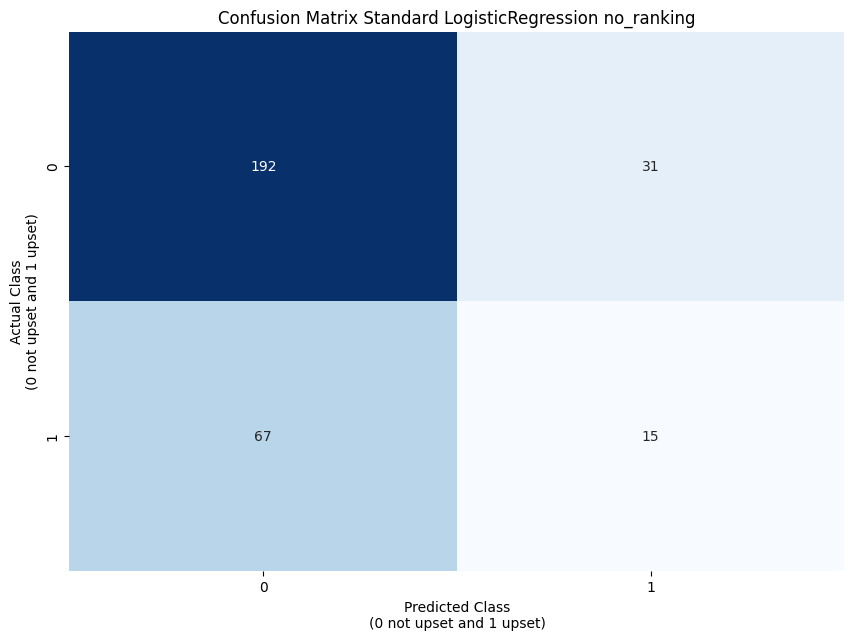

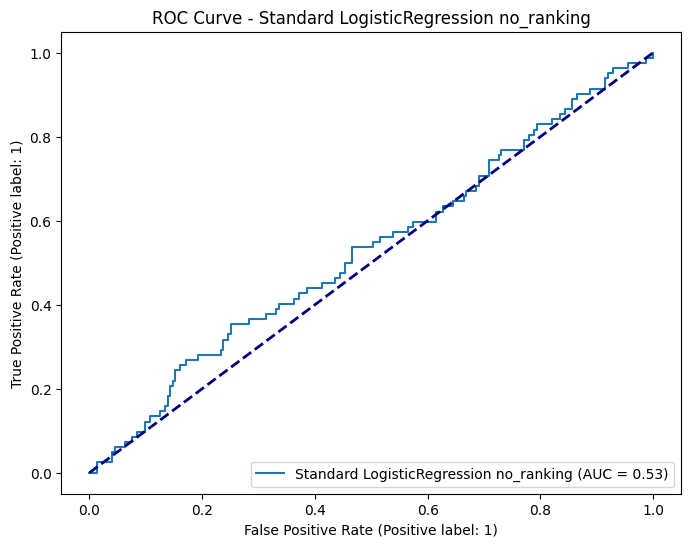

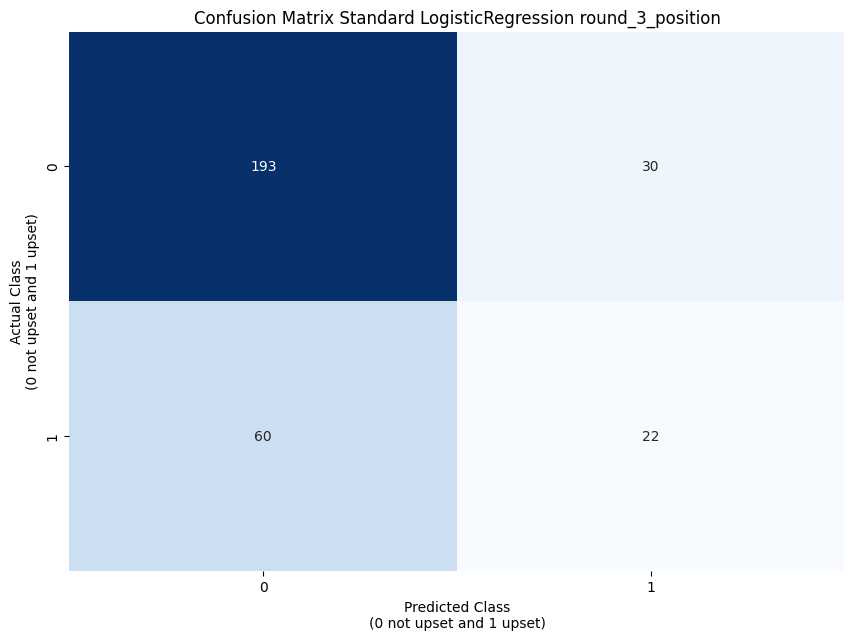

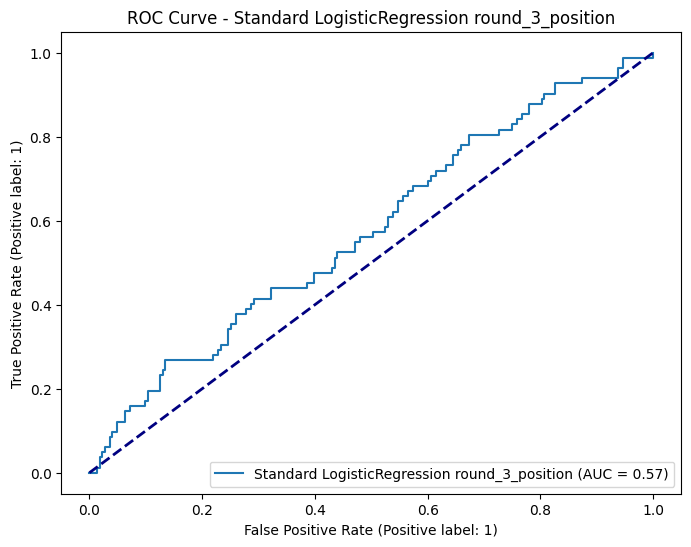

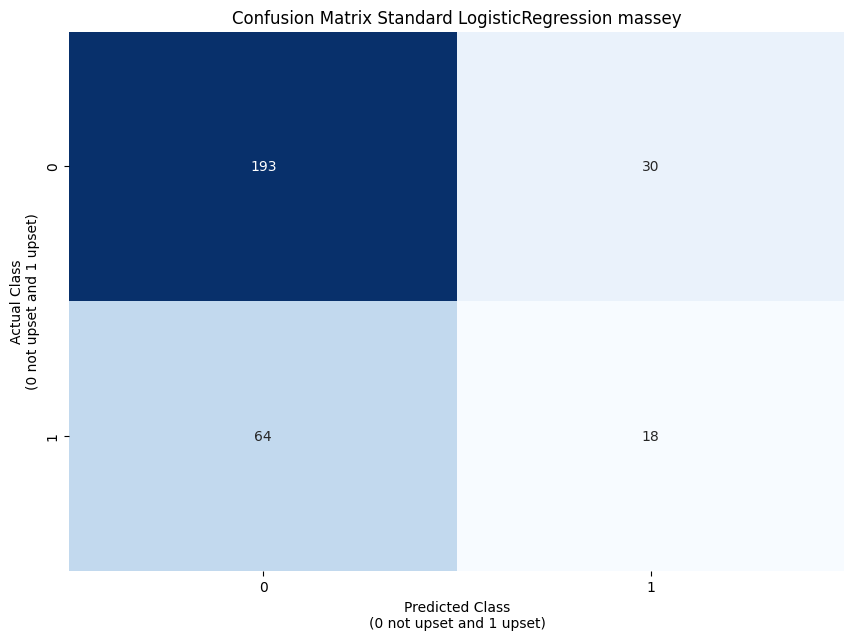

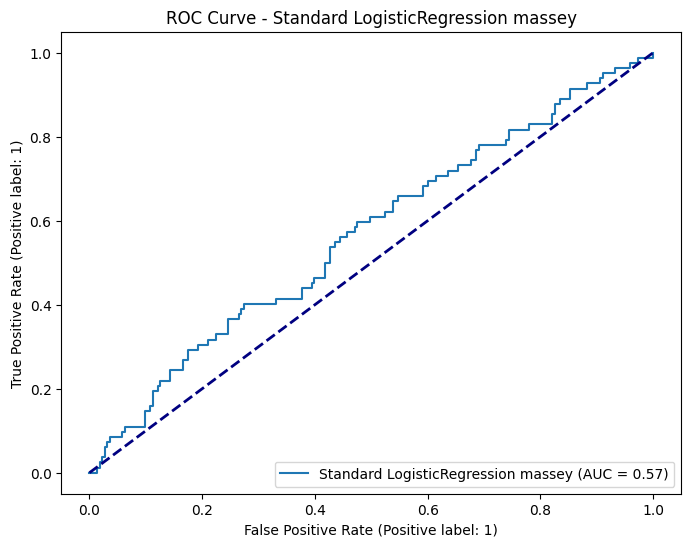

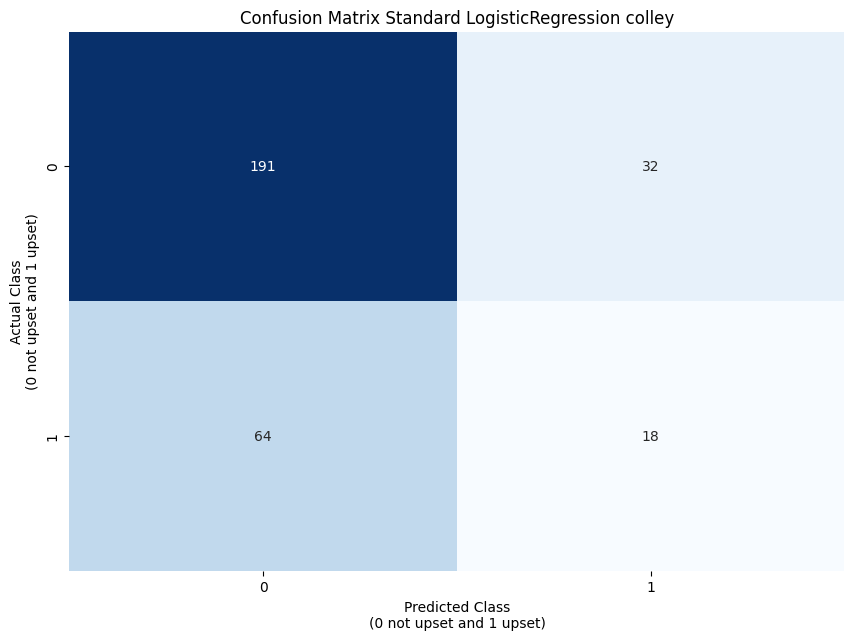

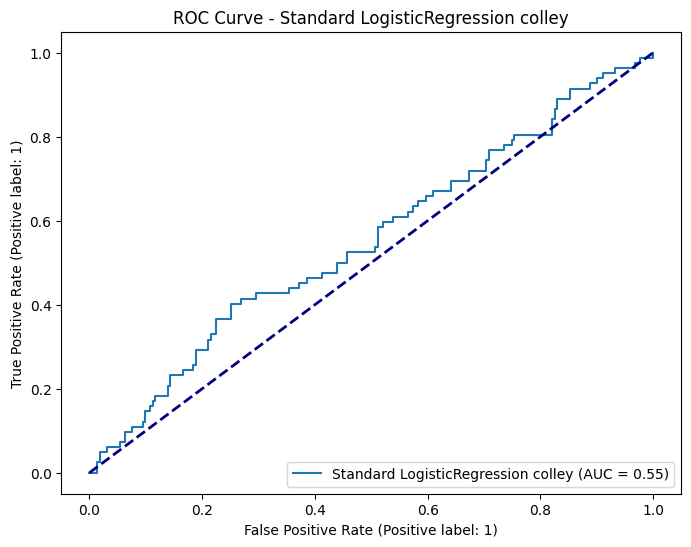

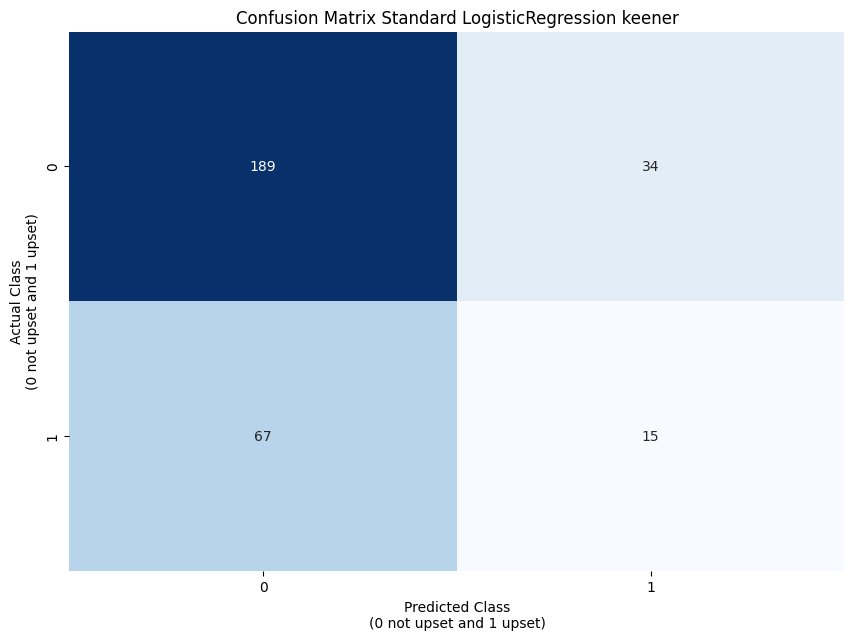

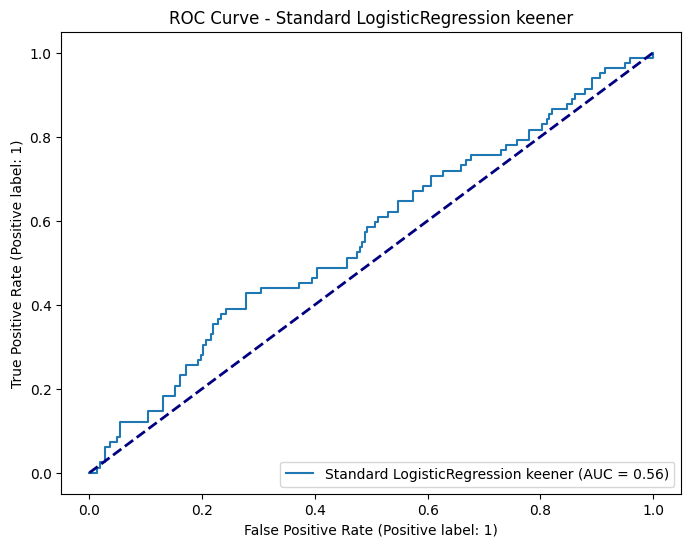

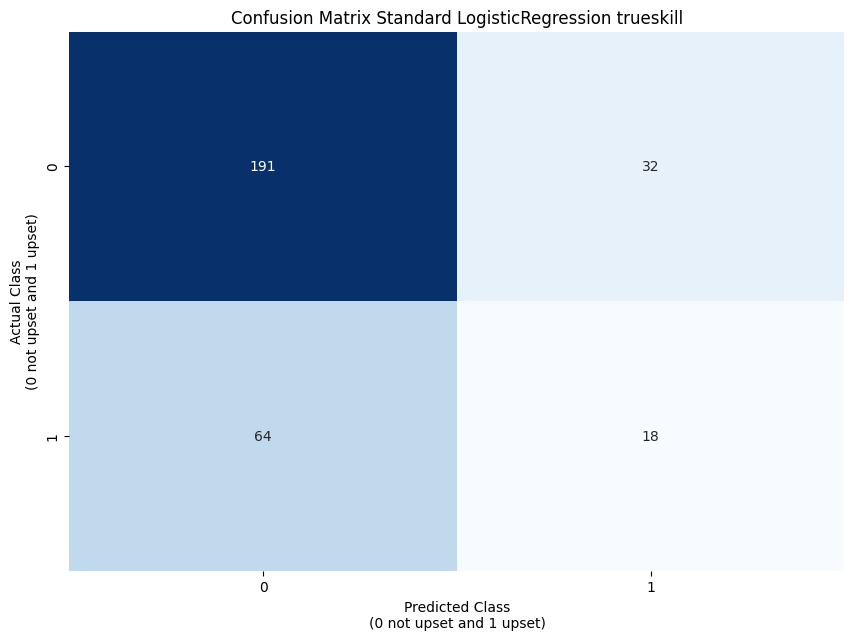

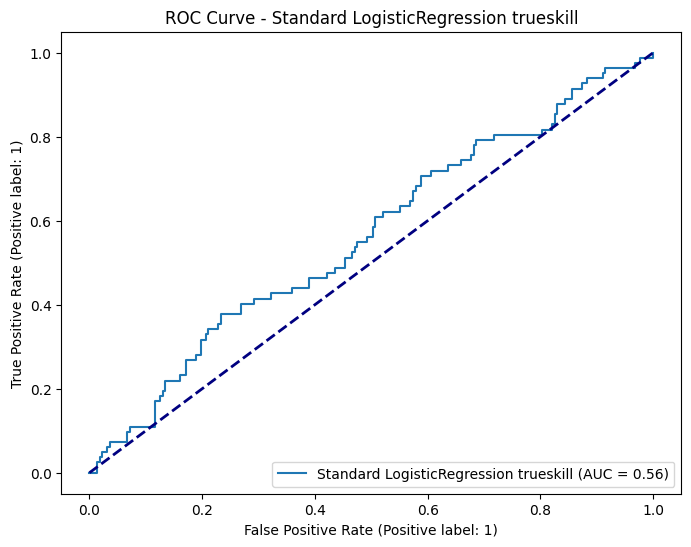

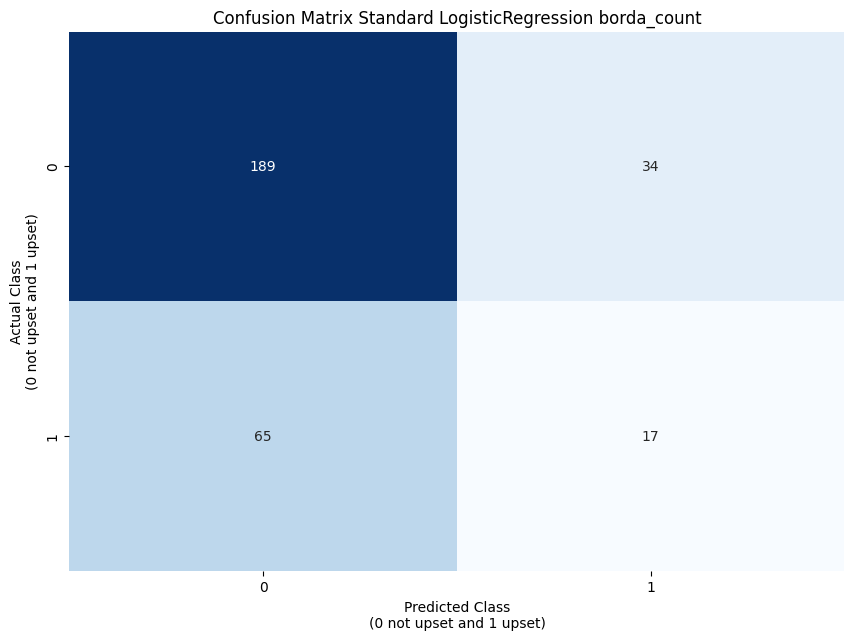

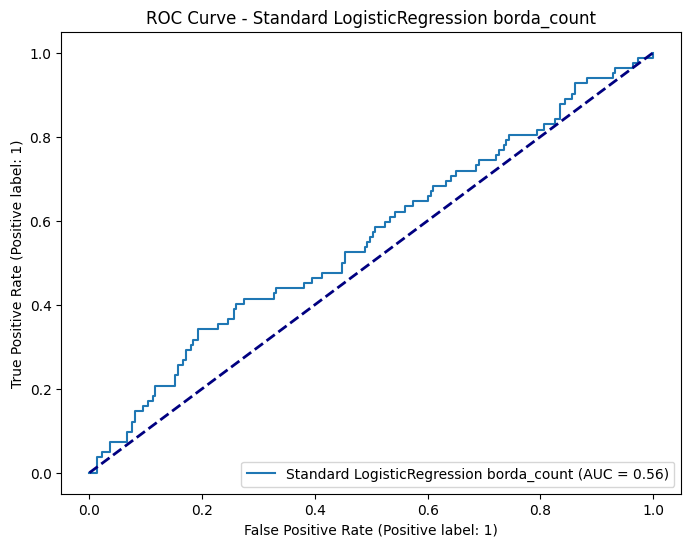

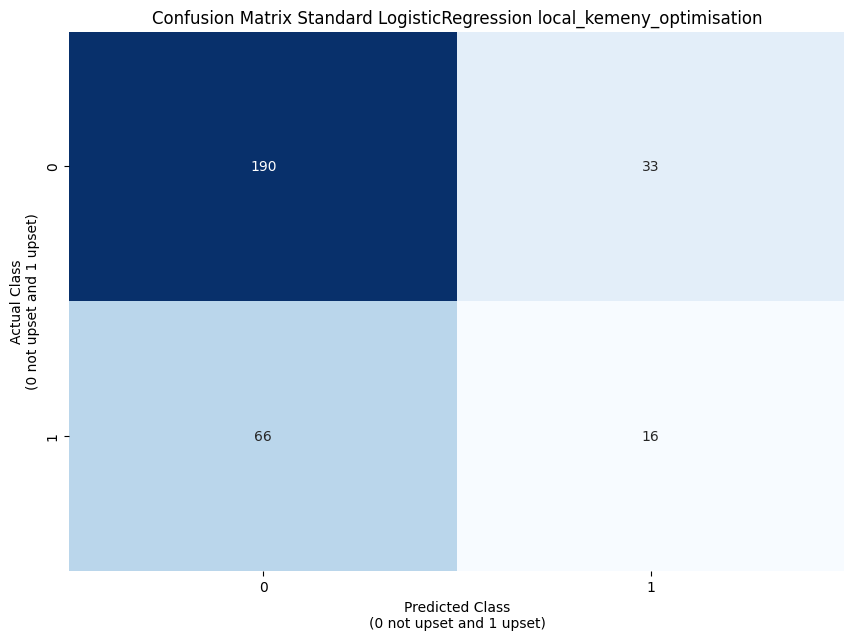

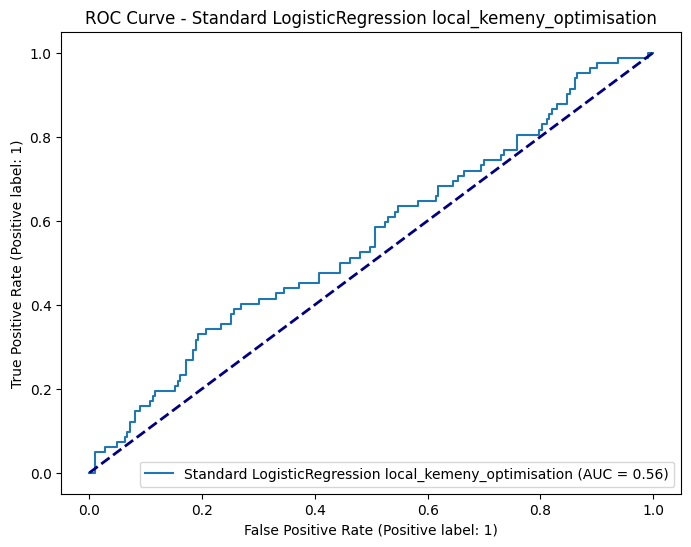

In [83]:
# Standard, no weights
model_name = "Standard LogisticRegression"
home_advt = 'no'
weighted = 'no'
model_classifier  = LogisticRegression(max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state = 47)

all_results_df_slr = all_results_df
display(all_results_df_slr)

fold_results_df_slr = fold_results_df
display(fold_results_df_slr)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_slr.to_excel("all_slr_results.xlsx")
fold_results_df_slr.to_excel("fold_results_slr.xlsx")


In [ ]:
# Standard, no weights with home advantage
model_name = "Standard LogisticRegression with home advantage"
home_adv = 'yes'
weighted = 'no'
model_classifier  = LogisticRegression(max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state = 47)

all_results_df_slrh = all_results_df
display(all_results_df_slrh)

fold_results_df_slrh = fold_results_df
display(fold_results_df_slrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_slrh.to_excel("all_slr_results.xlsx")
fold_results_df_slrh.to_excel("fold_results_slr.xlsx")

In [ ]:
# Weighted Logistc Regression
model_name = "Weighted LogisticRegression"
home_adv = 'no'
weighted = 'yes'
model_classifier  = LogisticRegression(class_weight=weights, max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state = 47)

all_results_df_wlr = all_results_df
display(all_results_df_wlr)

fold_results_df_wlr = fold_results_df
display(fold_results_df_wlr)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlr.to_excel("all_wlr_results.xlsx")
fold_results_df_wlr.to_excel("fold_results_wlr.xlsx")

In [ ]:
# Weighted Logistc Regression with home advatange
model_name = "Weighted LogisticRegression with home advantage"
home_adv = 'yes'
weighted = 'yes'
model_classifier  = LogisticRegression(class_weight=weights, max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state = 47)

all_results_df_wlrh = all_results_df
display(all_results_df_wlrh)

fold_results_df_wlrh = fold_results_df
display(fold_results_df_wlrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlrh.to_excel("all_wlrh_results.xlsx")
fold_results_df_wlrh.to_excel("fold_results_wlrh.xlsx")

In [ ]:
# MCP Neural Network
model_name = "MLP Classifier Neural Network"
home_adv = 'no'
weighted = 'no'
model_classifier  = MLPClassifier(max_iter=10000, random_state=random_state)

# Define the parameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(10,10,10), (20,20,), (10,)],
    'activation': ['logistic', 'tanh', 'relu'],
    'learning_rate_init': [0.001, 0.01, 0.1],
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state = 47)

all_results_df_wlrh = all_results_df
display(all_results_df_wlrh)

fold_results_df_wlrh = fold_results_df
display(fold_results_df_wlrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlrh.to_excel("all_wlrh_results.xlsx")
fold_results_df_wlrh.to_excel("fold_results_wlrh.xlsx")

In [ ]:
# MCP Neural Network
model_name = "MLP Classifier Neural Network"
random_state= 47

# Empty df for consolidating confusion report results
all_results_df_nn = pd.DataFrame(columns=['metric_id', 'metric'])

# Fold Grid SearchCV results
fold_results_nn = []

# Define the ranking systems
ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]


# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Loop through each ranking system
for ranking in ranking_systems:

    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    if ranking == 'no_ranking':
        # Use all base features without ranking
        X = fa_cup_raw_features_df[base_features]
    else:
        # Include ranking features
        current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
        X = fa_cup_raw_features_df[current_features]

    y = fa_cup_raw_features_df['target_variable']

    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []
    all_y_pred_proba = []  # Store probabilities for ROC

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Update preprocessor
        if ranking == 'no_ranking':
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ], verbose_feature_names_out=False)

        else:
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features),
                    ('rank', numeric_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
                ], verbose_feature_names_out=False)

        # Create pipeline
        pipeline = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', MLPClassifier(hidden_layer_sizes=(10), max_iter=10000, random_state=random_state))
          ])



        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class and ROC curve/AUC Score

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_pred_proba.extend(y_pred_proba)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using existing function
    results_df, cm_fig, roc_fig = create_model_results_df(all_y_true, all_y_pred, fold_accuracies,  all_y_pred_proba, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df_nn = all_results_df_nn.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df_nn)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nn.to_excel("all_nn_results.xlsx")

MLP Classifier Neural Network with home advantage no_ranking
Fold 1 Accuracy: 0.984
Fold 2 Accuracy: 0.951
Fold 3 Accuracy: 0.934
Fold 4 Accuracy: 0.984
Fold 5 Accuracy: 0.852
Average Accuracy: 0.941
MLP Classifier Neural Network with home advantage round_3_position
Fold 1 Accuracy: 1.000
Fold 2 Accuracy: 0.967
Fold 3 Accuracy: 0.951
Fold 4 Accuracy: 0.967
Fold 5 Accuracy: 0.902
Average Accuracy: 0.957
MLP Classifier Neural Network with home advantage massey
Fold 1 Accuracy: 1.000
Fold 2 Accuracy: 0.967
Fold 3 Accuracy: 0.951
Fold 4 Accuracy: 0.934
Fold 5 Accuracy: 0.836
Average Accuracy: 0.938
MLP Classifier Neural Network with home advantage colley
Fold 1 Accuracy: 0.984
Fold 2 Accuracy: 0.984
Fold 3 Accuracy: 0.934
Fold 4 Accuracy: 0.967
Fold 5 Accuracy: 0.902
Average Accuracy: 0.954
MLP Classifier Neural Network with home advantage keener
Fold 1 Accuracy: 0.984
Fold 2 Accuracy: 0.967
Fold 3 Accuracy: 0.934
Fold 4 Accuracy: 0.967
Fold 5 Accuracy: 0.836
Average Accuracy: 0.938
MLP Cl

,metric_id,metric,MLP Classifier Neural Network with home advantage no_ranking,MLP Classifier Neural Network with home advantage round_3_position,MLP Classifier Neural Network with home advantage massey,MLP Classifier Neural Network with home advantage colley,MLP Classifier Neural Network with home advantage keener,MLP Classifier Neural Network with home advantage trueskill,MLP Classifier Neural Network with home advantage borda_count,MLP Classifier Neural Network with home advantage local_kemeny_optimisation
0,1,Cross-validation Accuracy,0.941,0.957,0.938,0.954,0.938,0.951,0.954,0.944
1,2,Cross-validation Standard Deviation,0.048,0.032,0.055,0.032,0.053,0.031,0.022,0.030
2,3,Overall Accuracy,0.941,0.957,0.938,0.954,0.938,0.951,0.954,0.944
3,4,Confusion Matrix - True Negative (Class 0),220.000,219.000,220.000,219.000,218.000,219.000,220.000,219.000
4,5,Confusion Matrix - False Positive (Class 1),3.000,4.000,3.000,4.000,5.000,4.000,3.000,4.000
5,6,Confusion Matrix - False Negative (Class 0),15.000,9.000,16.000,10.000,14.000,11.000,11.000,13.000
6,7,Confusion Matrix - True Positive (Class 1),67.000,73.000,66.000,72.000,68.000,71.000,71.000,69.000
7,8,Precision (Class 0),0.936,0.961,0.932,0.956,0.940,0.952,0.952,0.944
8,9,Recall (Class 0),0.987,0.982,0.987,0.982,0.978,0.982,0.987,0.982
9,10,F1-score (Class 0),0.961,0.971,0.959,0.969,0.958,0.967,0.969,0.963


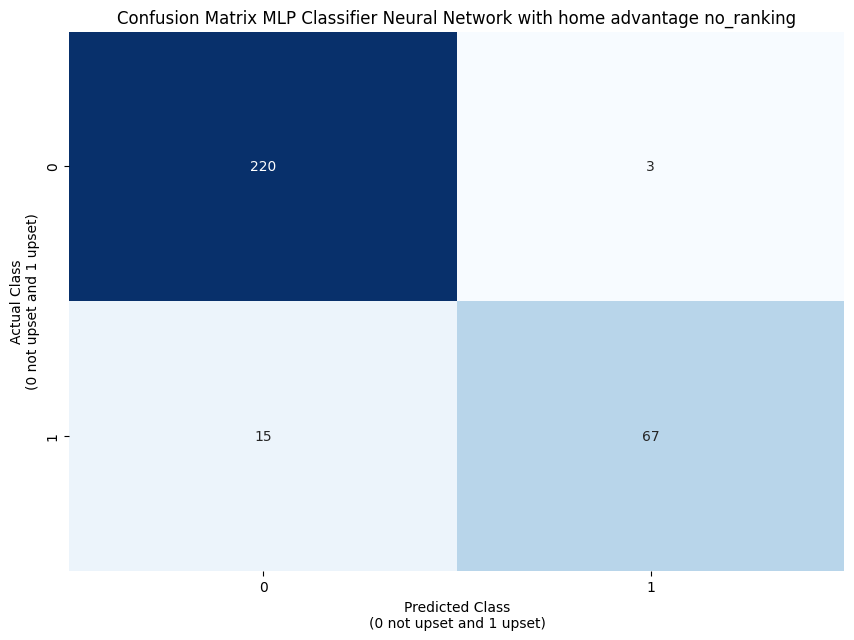

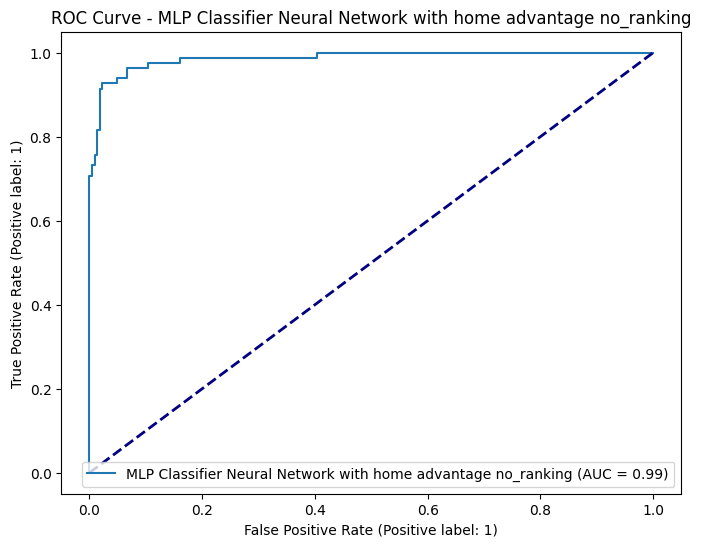

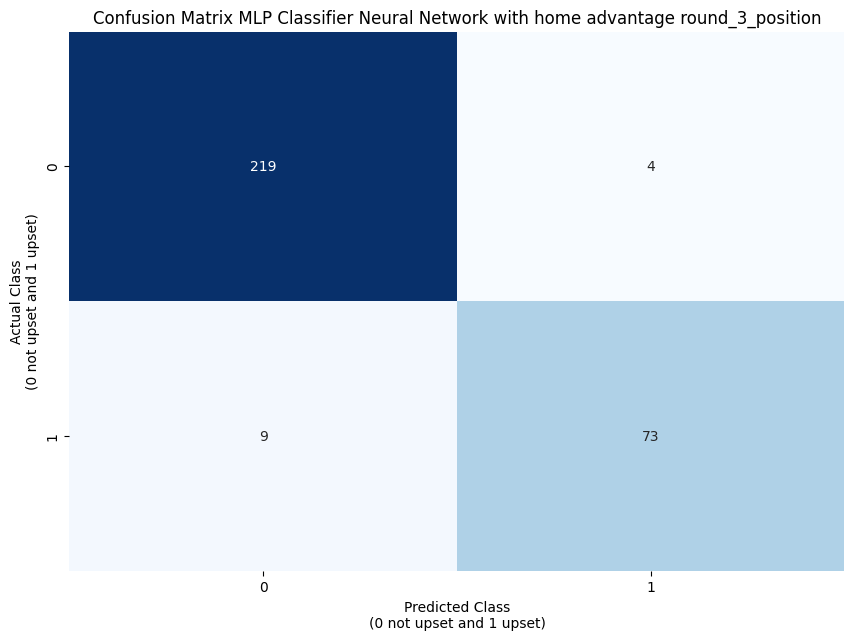

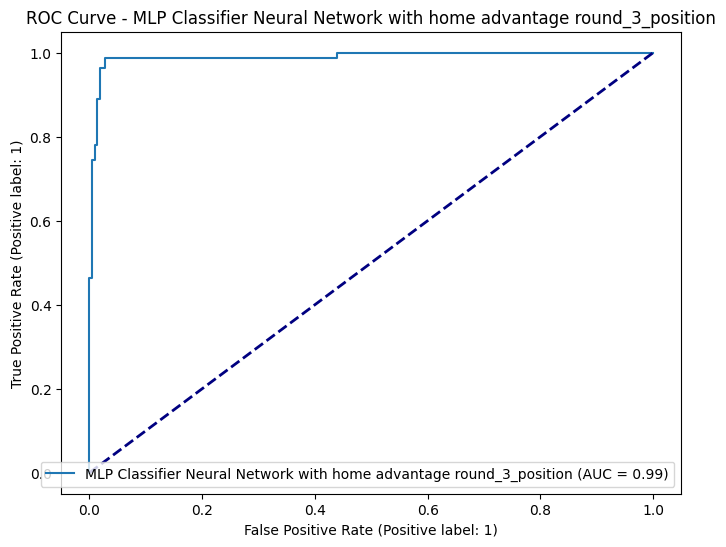

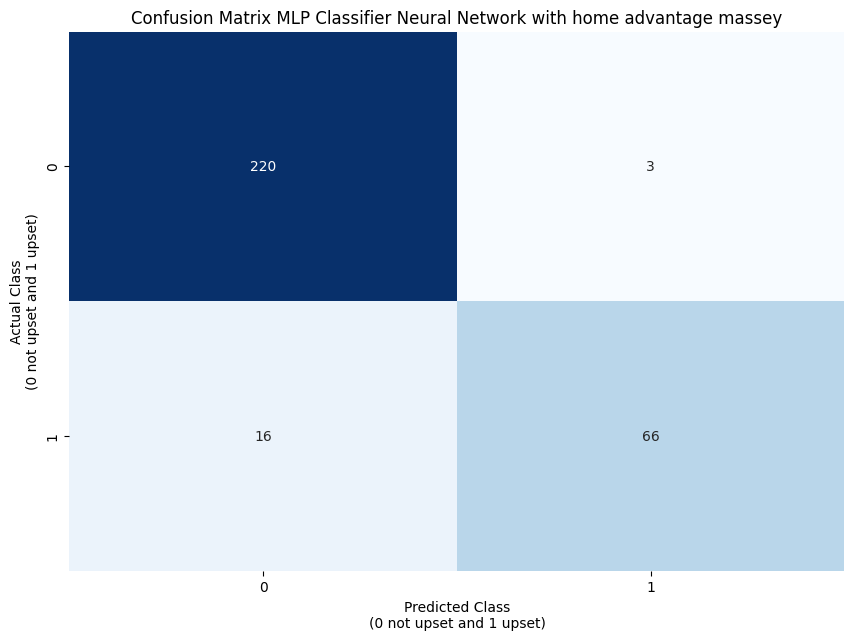

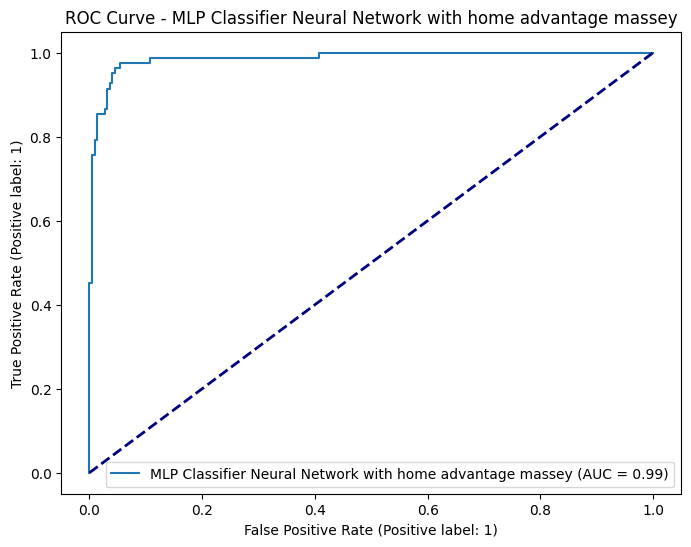

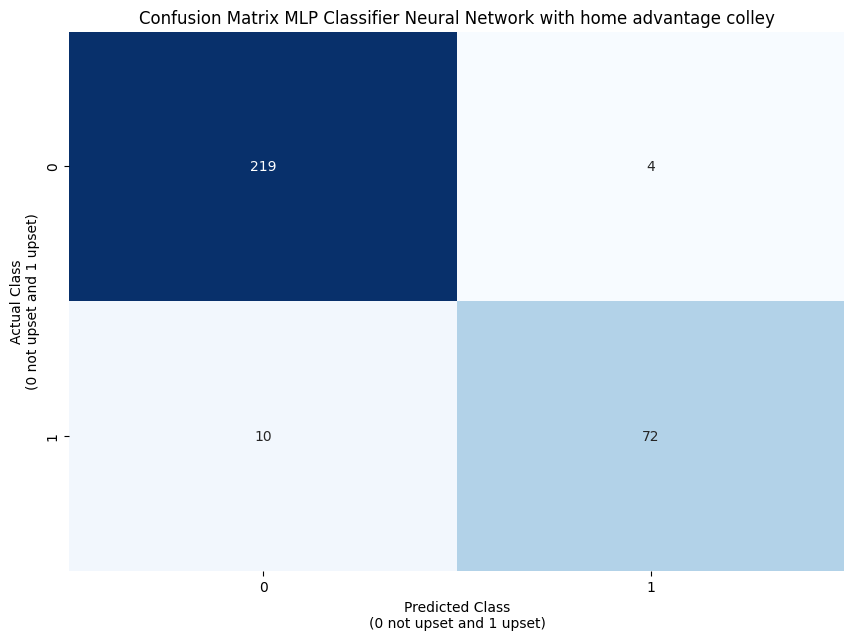

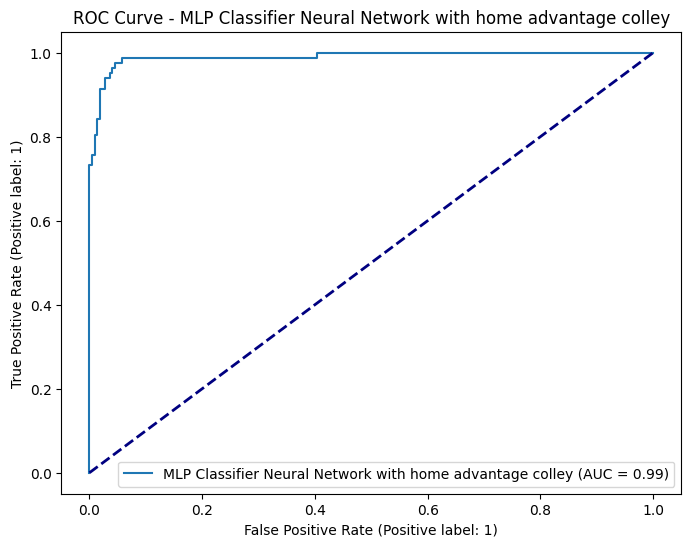

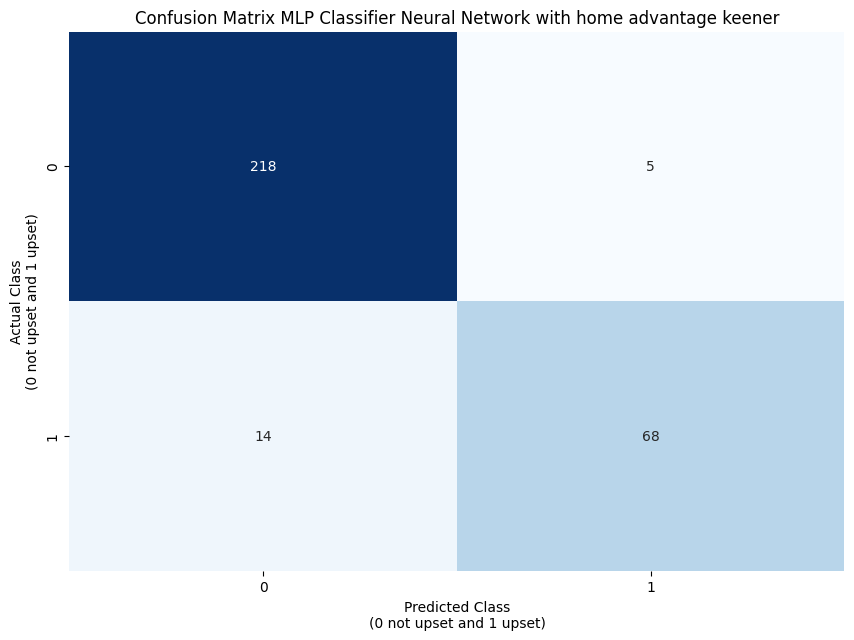

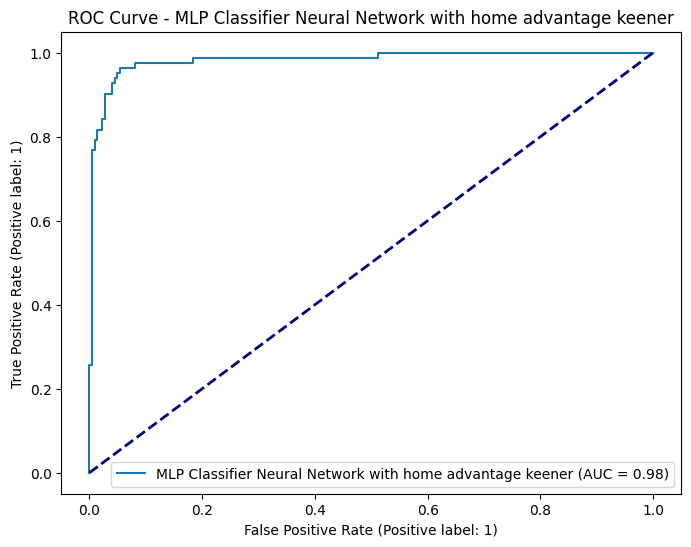

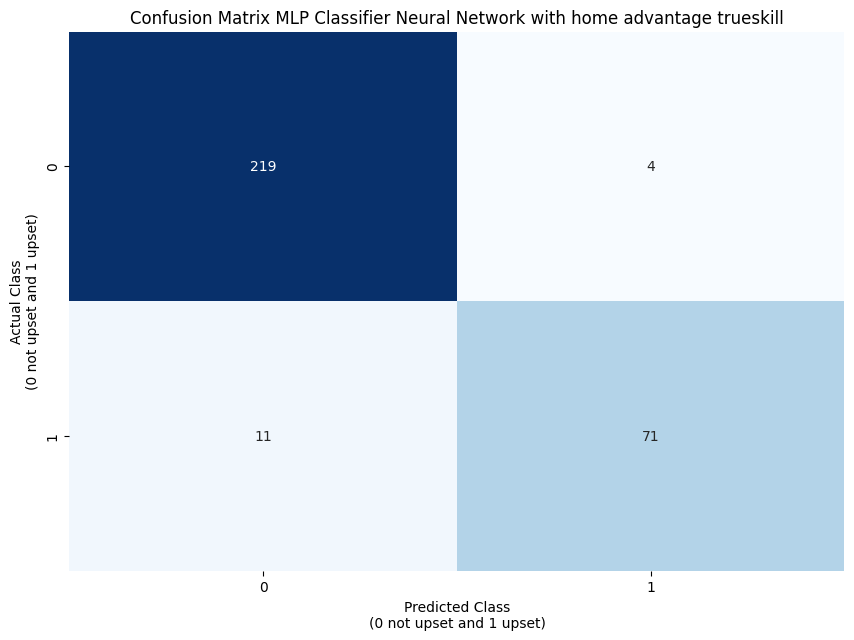

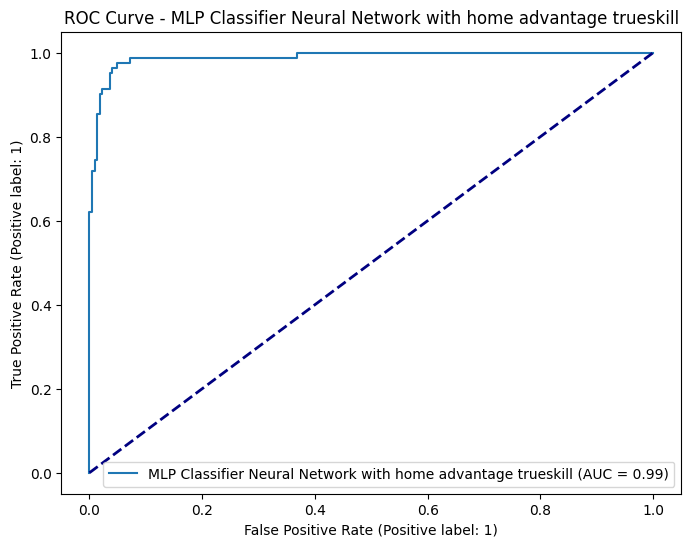

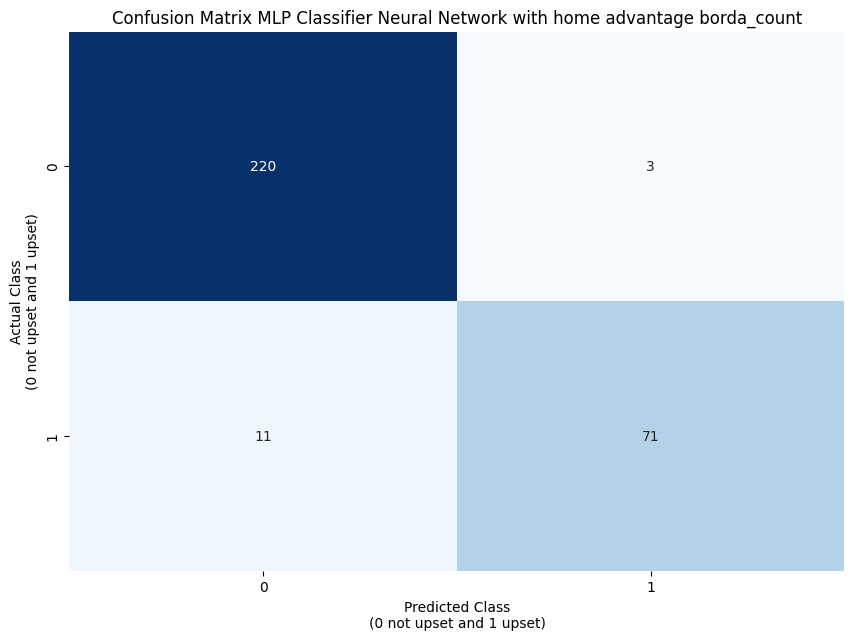

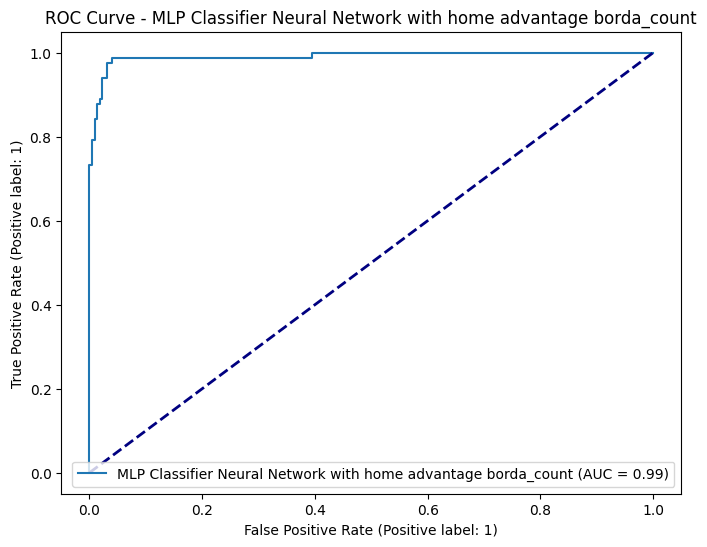

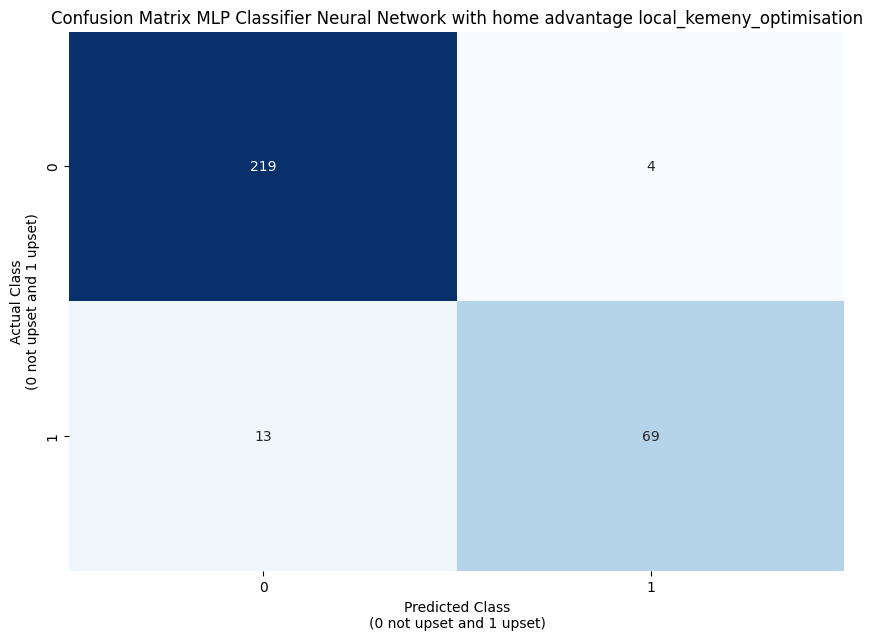

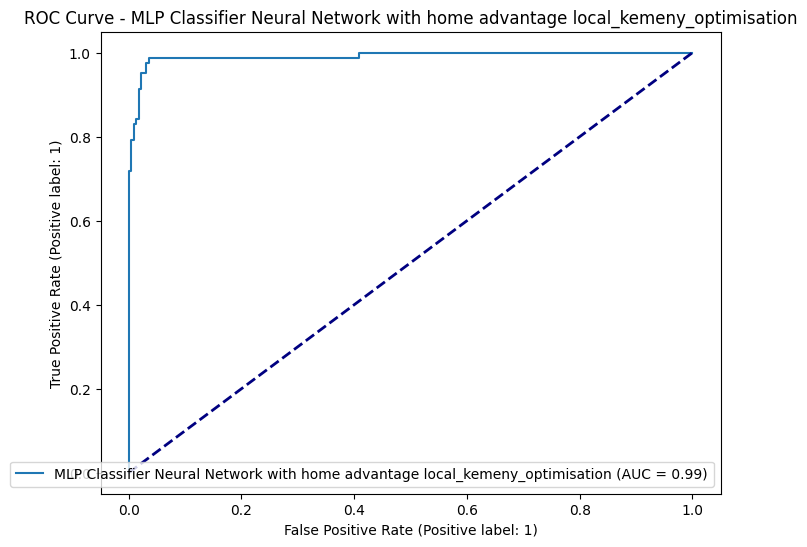

In [ ]:
# MCP Neural Network with home advantage
model_name = "MLP Classifier Neural Network with home advantage"
random_state= 47

# Empty df for consolidating confusion report results
all_results_df_nnh = pd.DataFrame(columns=['metric_id', 'metric'])

# Define the ranking systems
ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]


# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Loop through each ranking system
for ranking in ranking_systems:
    #print(f"\nRunning model for {ranking} ranking system")
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    if ranking == 'no_ranking':
        # Use all base features without ranking
        X = fa_cup_raw_features_df[base_features]
    else:
        # Prepare the feature set for the current ranking system to Include ranking features
        current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
        X = fa_cup_raw_features_df[current_features]

    y = fa_cup_raw_features_df['target_variable']

    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []
    all_y_pred_proba = []  # Store probabilities for ROC

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Add home advantage factor
        X_train, home_advantage_column = add_home_advantage(X_train)
        X_val, _ = add_home_advantage(X_val)

        # Update numeric_features to include the home advantage column
        numeric_features_with_ha = [home_advantage_column] + numeric_features

         # Update preprocessor with current features including home advantage
        if ranking == 'no_ranking':
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ], verbose_feature_names_out=False)

        else:
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features),
                    ('rank', numeric_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
                ], verbose_feature_names_out=False)

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)


        # Create pipeline
        model = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', MLPClassifier(hidden_layer_sizes=(10), max_iter=10000, random_state=random_state))
          ])

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class and ROC curve/AUC Score

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_pred_proba.extend(y_pred_proba)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using existing function
    results_df, cm_fig, roc_fig = create_model_results_df(all_y_true, all_y_pred, fold_accuracies,  all_y_pred_proba, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df_nnh = all_results_df_nnh.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df_nnh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nnh.to_excel("all_nnh_results.xlsx")


In [ ]:
all_results_df_lr = all_results_df_slrh.merge(all_results_df_slr, on=['metric_id', 'metric'], how='outer')
all_results_df_slnn = all_results_df_nn.merge(all_results_df_lr, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nnh.merge(all_results_df_slnn, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Load updated Confusion Matrix results to Google Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'lr_ann_model_confusion_matrix_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_results_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')